In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Agent representing a node in the network
class NetworkAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.is_bot = random.choice([True, False])  # Randomly decide if this agent is a bot
        self.packet_count = 0  # Traffic count per agent

    def step(self):
        """Generates traffic based on agent type."""
        if self.is_bot:
            # Generate traffic indicative of a DDoS attack
            self.packet_count = random.randint(5, 15)  # Higher traffic for bots
        else:
            # Generate normal traffic
            self.packet_count = random.randint(1, 5)  # Normal user traffic

# Model to simulate network with users and bots
class NetworkModel(Model):
    def __init__(self, num_agents):
        self.num_agents = num_agents  # Total number of agents
        self.schedule = RandomActivation(self)
        self.total_traffic = []
        
        # Create agents
        for i in range(self.num_agents):
            agent = NetworkAgent(i, self)
            self.schedule.add(agent)
    
    def step(self):
        """Advances the model by one step, updating traffic count."""
        self.schedule.step()
        total_packets = sum(agent.packet_count for agent in self.schedule.agents)
        self.total_traffic.append(total_packets)

    def calculate_entropy(self, window):
        """Calculates the entropy of the traffic window using a histogram."""
        counts, _ = np.histogram(window, bins=np.arange(min(window), max(window) + 2))
        prob_dist = counts + 1e-6  # Avoid zero counts
        prob_dist = prob_dist / prob_dist.sum()  # Normalize to get probabilities
        return entropy(prob_dist)  # Use scipy's entropy function

# Parameters
N = 500  # Total number of agents
window_size = 40  # Define window size globally
num_steps = 200  # Total simulation steps

# Initialize the model
model = NetworkModel(N)

# Simulate network for specified number of time steps
for _ in range(num_steps):
    model.step()

def detect_attacks_abm(traffic_data, threshold=3.60):
    """Detects DDoS attacks based on entropy of traffic data."""
    detected_attacks = []
    abm_entropy = []

    # Sliding window entropy calculation
    for i in range(len(traffic_data) - window_size + 1):
        window = traffic_data[i:i + window_size]
        # Calculate entropy for the current window
        current_entropy = model.calculate_entropy(window)
        abm_entropy.append(current_entropy)
        # Detect if entropy is above the threshold (high entropy indicates a potential attack)
        if current_entropy > threshold:
            detected_attacks.append(i + window_size // 2)  # Mark the midpoint as an attack period
   
    return abm_entropy, detected_attacks

# Call the detection function
threshold = 3.60
entropy_values, attack_periods = detect_attacks_abm(model.total_traffic)

/Users/bedabratachoudhury/miniconda3/envs/myenv/lib/python3.9/site-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)


In [4]:
import pandas as pd

# Convert one of the nodes' time series to stock prices
series = model.total_traffic

# Normalize the traffic to a realistic range
min_v, max_v = 3100, 4500
normalized = np.interp(series, (min(series), max(series)), (min_v, max_v))

# Create a date range
xvals=np.arange(0,len(normalized))
df = pd.DataFrame(data={'xvals': xvals, 'Traffic': normalized})

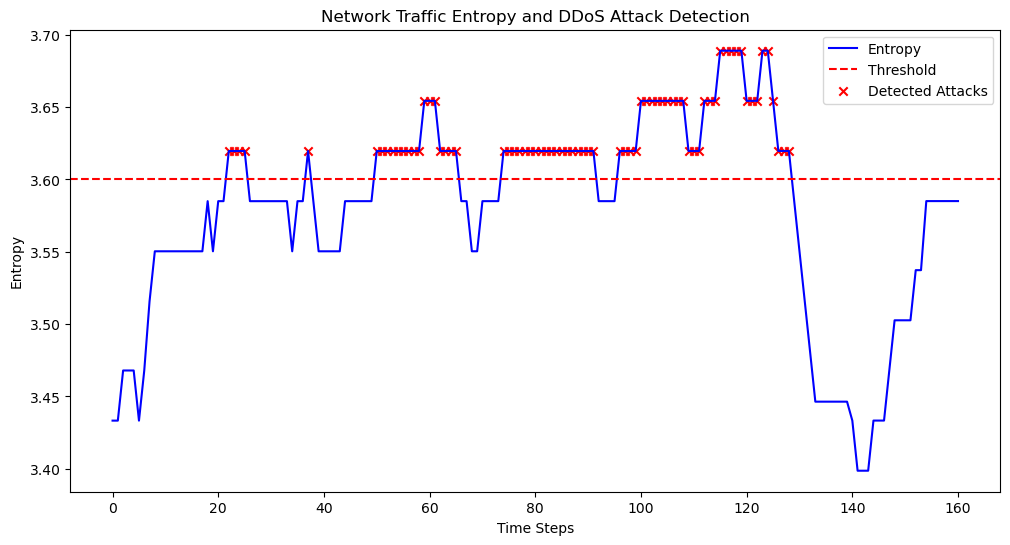

In [5]:
# Optional: Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(entropy_values, label='Entropy', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
# Ensure we reference only valid indices for the scatter plot
valid_attack_periods = [p - window_size // 2 for p in attack_periods if p - window_size // 2 >= 0]
plt.scatter(valid_attack_periods, [entropy_values[i] for i in valid_attack_periods], color='red', marker='x', label='Detected Attacks')
plt.title('Network Traffic Entropy and DDoS Attack Detection')
plt.xlabel('Time Steps')
plt.ylabel('Entropy')
plt.legend()
plt.show()

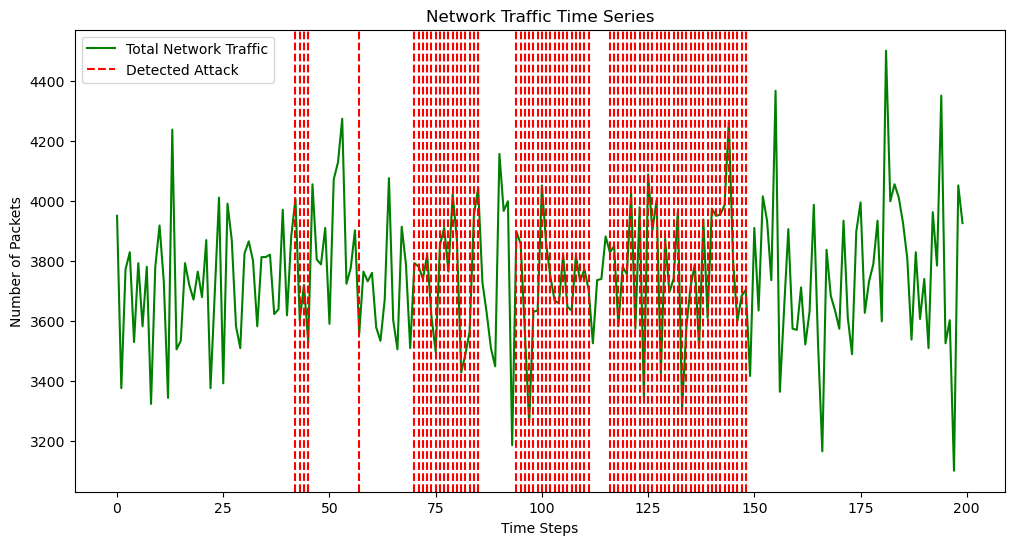

In [6]:
# Assuming the previous code has been executed and we have `entropy_values` and `attack_periods` defined

# Plot the time series of network traffic
plt.figure(figsize=(12, 6))
plt.plot(df['Traffic'], label='Total Network Traffic', color='green')
plt.title('Network Traffic Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Number of Packets')

# Highlight the detected attack periods
for attack_time in attack_periods:
    plt.axvline(x=attack_time, color='red', linestyle='--', label='Detected Attack' if attack_time == attack_periods[0] else "")

plt.legend()
plt.show()

In [7]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [8]:
import numpy as np
import random
from collections import deque
import pickle
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from scipy.stats import entropy as scipy_entropy  # Import entropy function from scipy.stats

In [9]:
class NetworkTrafficEnvironment:
    def __init__(self, traffic_data, window_size=40, initial_entropy_threshold=3.60):
        self.traffic_data = traffic_data  # Simulated network traffic data (e.g., packet counts)
        self.window_size = window_size
        self.entropy_threshold = initial_entropy_threshold  # Manually set initial entropy threshold
        self.entropy_values = []  # Store calculated entropy values from the sliding window
        self.reset()

    def reset(self):
        """Resets the environment for a new episode."""
        self.current_step = 0
        self.entropy_values.clear()  # Clear stored entropy values
        print("Environment reset.")
        return self.get_state()

    def get_state(self):
        """Gets the current state of the traffic, padded if necessary."""
        start = max(0, self.current_step - self.window_size + 1)
        state = self.traffic_data[start:self.current_step + 1]
        state = np.pad(state, (self.window_size - len(state), 0), 'constant')  # Pad the state
        return state

    def calculate_entropy(self, window):
        """Calculates the entropy of the traffic window using a histogram."""
        counts, _ = np.histogram(window, bins=np.arange(min(window), max(window) + 2))
        prob_dist = counts + 1e-6  # Avoid zero counts
        prob_dist = prob_dist / prob_dist.sum()  # Normalize to get probabilities
        entropy_value = entropy(prob_dist)  # Calculate entropy using scipy's entropy function
        return entropy_value

    def compute_entropy_values(self):
        """Calculates entropy values for each sliding window of traffic data."""
        self.entropy_values.clear()  # Clear previous entropy values
        for i in range(len(self.traffic_data) - self.window_size + 1):
            window = self.traffic_data[i:i + self.window_size]
            current_entropy = self.calculate_entropy(window)
            self.entropy_values.append(current_entropy)  # Store the entropy value for this window

    def adjust_entropy_threshold(self):
        """Dynamically adjusts the entropy threshold based on observed values."""
        if len(self.entropy_values) > 10:  # Adjust threshold if enough values are recorded
            avg_entropy = np.mean(self.entropy_values[-10:])  # Average over the last 10 values
            self.entropy_threshold = avg_entropy + 0.1  # Example adjustment
            print(f"Adjusted entropy threshold: {self.entropy_threshold:.2f}")

    def take_action(self, action):
        """Takes an action based on the current traffic state and the calculated entropy."""
        current_traffic = self.traffic_data[self.current_step]
        reward = 0

        # Get the traffic window for entropy calculation
        traffic_window = self.traffic_data[max(0, self.current_step - self.window_size + 1):self.current_step + 1]
        
        # Calculate entropy for the current traffic window
        entropy_value = self.calculate_entropy(traffic_window)

        # Define actions:
        # 0: Allow traffic, 1: Throttle traffic, 2: Block traffic
        if action == 0:  # Allow
            if entropy_value > self.entropy_threshold:  # High entropy indicates potential anomaly
                reward = -5  # Strong penalty for allowing potentially malicious traffic
            else:
                reward = 2  # Reward for allowing normal traffic

        elif action == 1:  # Throttle
            if entropy_value > self.entropy_threshold:  # High entropy indicates potential anomaly
                reward = 4  # Moderate reward for throttling high entropy traffic
            else:
                reward = 1  # Mild reward for normal throttling

        elif action == 2:  # Block
            if entropy_value > self.entropy_threshold:  # High entropy indicates potential anomaly
                reward = 10  # Strong reward for effectively blocking high entropy traffic
            else:
                reward = -4  # Penalty for blocking normal traffic, as it disrupts legitimate users

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.traffic_data) - 1
        
        # Adjust entropy threshold after each step
        self.adjust_entropy_threshold()

        print(f"Step: {self.current_step}, Action: {['Allow', 'Throttle', 'Block'][action]}, "
              f"Traffic: {current_traffic}, Entropy: {entropy_value:.2f}, Reward: {reward:.2f}")

        return self.get_state(), reward, done


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)  # Increased memory size
        self.gamma = 0.99  # Closer to 1 for long-term rewards
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_decay = 0.995  # Slower decay for more exploration
        self.epsilon_min = 0.05  # Allow exploration to stay longer
        self.learning_rate = 0.0005  # Lower learning rate
        self.model = self._build_model()

    def _build_model(self):
        """Builds the neural network model for the DQN agent."""
        model = Sequential()
        model.add(LSTM(128, input_shape=(self.state_size, 1), return_sequences=True))  # Increased layer size
        model.add(LSTM(64))  # Added a second LSTM layer
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer="adam")  # Reduced learning rate
        return model

    def remember(self, state, action, reward, next_state, done):
        """Stores experiences in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        """Chooses an action based on the current state."""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(np.reshape(state, (1, self.state_size, 1)))
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        """Replays experiences from memory to train the agent."""
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.amax(self.model.predict(np.reshape(next_state, (1, self.state_size, 1)))[0])
            target_f = self.model.predict(np.reshape(state, (1, self.state_size, 1)))
            target_f[0][action] = target
            self.model.fit(np.reshape(state, (1, self.state_size, 1)), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save_model(self, name):
        """Saves the model weights."""
        self.model.save_weights(name)

    def load_model(self, name):
        """Loads model weights."""
        self.model.load_weights(name)

    def save_q_values(self, states, filename):
        """Saves Q-values for given states to a file."""
        q_values_dict = {}
        for state in states:
            state_reshaped = np.reshape(state, (1, self.state_size, 1))
            q_values = self.model.predict(state_reshaped)[0]
            q_values_dict[str(state.tolist())] = q_values.tolist()

        # Save Q-values dictionary to a file
        with open(filename, 'wb') as f:
            pickle.dump(q_values_dict, f)


class DDoSDetectionAgent:
    def __init__(self, traffic_data):
        self.env = NetworkTrafficEnvironment(traffic_data)
        self.state_size = self.env.window_size  # Use the window size for state representation
        self.action_size = 3  # Actions: Allow, Throttle, Block
        self.agent = DQNAgent(self.state_size, self.action_size)

    def train(self, epochs, batch_size=32, update_target_every=5):
        """Trains the agent for a specified number of epochs."""
        for e in range(epochs):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])

            total_reward = 0  # Track total reward for this episode
            for time in range(len(self.env.traffic_data) - 1):
                action = self.agent.choose_action(state)
                next_state, reward, done = self.env.take_action(action)
                next_state = np.reshape(next_state, [1, self.state_size])

                # Store experience and train the agent
                self.agent.remember(state, action, reward, next_state, done)
                state = next_state
            
                total_reward += reward  # Update total reward

                if done:
                    break

            print(f"Episode: {e + 1}/{epochs}, Total Reward: {total_reward}")  # Log episode performance

Environment reset.


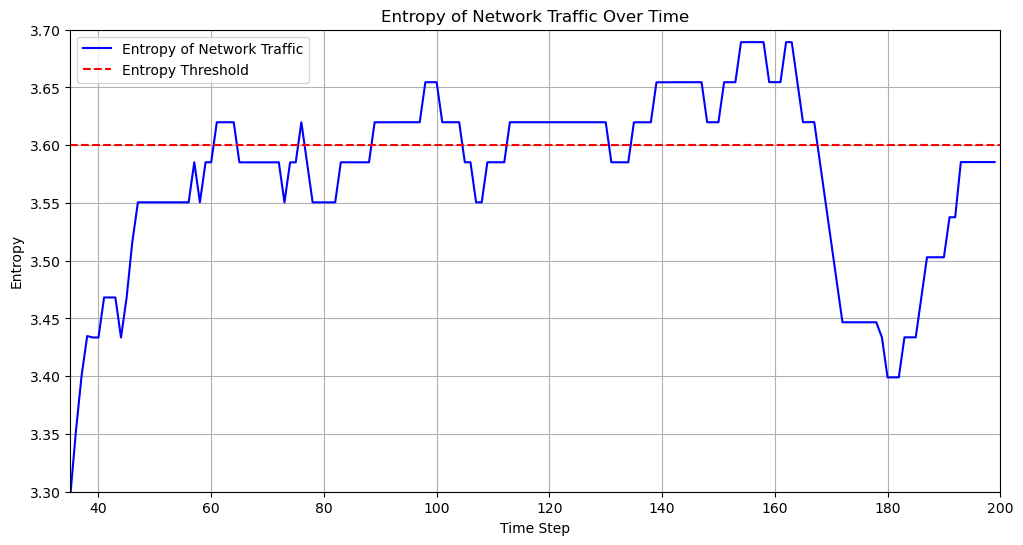

In [10]:
#Verify if entropy is being calculated correctly :

# Create an instance of the environment
env = NetworkTrafficEnvironment(df['Traffic'], window_size=40)

entropy_values=[]

# Calculate entropy for each step in the traffic data
for step in range(len(model.total_traffic)):
    env.current_step = step  # Update the current step
    traffic_window = env.get_state()  # Get the current state (traffic window)
    entropy_value = env.calculate_entropy(traffic_window)  # Calculate entropy
    entropy_values.append(entropy_value)  # Store the entropy value

# Plotting the entropy values
plt.figure(figsize=(12, 6))
plt.plot(entropy_values, label='Entropy of Network Traffic', color='blue')
plt.title('Entropy of Network Traffic Over Time')
plt.xlabel('Time Step')
plt.ylabel('Entropy')
plt.xlim(35,200) # Change these as per needed
plt.ylim(3.3,3.7) # Change these as per needed
plt.axhline(y=env.entropy_threshold, color='red', linestyle='--', label='Entropy Threshold')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Initialize the DDoS Detection Agent
ddos_agent = DDoSDetectionAgent(traffic_data=df['Traffic'])

# Train the agent
epochs = 100 # Define the number of training episodes
batch_size = 32  # Size of the mini-batch for experience replay
ddos_agent.train(epochs, batch_size)

Environment reset.


2024-10-23 01:07:02.210755: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Environment reset.
Step: 1, Action: Allow, Traffic: 3949.7109826589594, Entropy: 0.00, Reward: 2.00
Step: 2, Action: Allow, Traffic: 3375.1445086705203, Entropy: 0.70, Reward: 2.00
Step: 3, Action: Allow, Traffic: 3771.676300578035, Entropy: 1.10, Reward: 2.00
Step: 4, Action: Block, Traffic: 3828.3236994219656, Entropy: 1.39, Reward: -4.00
Step: 5, Action: Allow, Traffic: 3528.901734104046, Entropy: 1.61, Reward: 2.00
Step: 6, Action: Allow, Traffic: 3791.907514450867, Entropy: 1.79, Reward: 2.00
Step: 7, Action: Block, Traffic: 3581.5028901734104, Entropy: 1.95, Reward: -4.00
Step: 8, Action: Allow, Traffic: 3779.768786127168, Entropy: 2.08, Reward: 2.00
Step: 9, Action: Block, Traffic: 3322.543352601156, Entropy: 2.20, Reward: -4.00
Step: 10, Action: Throttle, Traffic: 3779.768786127168, Entropy: 2.16, Reward: 1.00
Step: 11, Action: Allow, Traffic: 3917.341040462428, Entropy: 2.27, Reward: 2.00
Step: 12, Action: Block, Traffic: 3731.21387283237, Entropy: 2.37, Reward: -4.00
Step: 13

Step: 161, Action: Allow, Traffic: 3569.364161849711, Entropy: 3.65, Reward: -5.00
Step: 162, Action: Block, Traffic: 3710.9826589595377, Entropy: 3.65, Reward: 10.00
Step: 163, Action: Allow, Traffic: 3520.809248554913, Entropy: 3.69, Reward: -5.00
Step: 164, Action: Throttle, Traffic: 3630.057803468208, Entropy: 3.69, Reward: 4.00
Step: 165, Action: Allow, Traffic: 3986.127167630058, Entropy: 3.65, Reward: -5.00
Step: 166, Action: Block, Traffic: 3520.809248554913, Entropy: 3.62, Reward: 10.00
Step: 167, Action: Block, Traffic: 3164.7398843930637, Entropy: 3.62, Reward: 10.00
Step: 168, Action: Allow, Traffic: 3836.416184971098, Entropy: 3.62, Reward: -5.00
Step: 169, Action: Allow, Traffic: 3682.658959537572, Entropy: 3.59, Reward: 2.00
Step: 170, Action: Block, Traffic: 3634.1040462427745, Entropy: 3.55, Reward: -4.00
Step: 171, Action: Block, Traffic: 3573.4104046242774, Entropy: 3.52, Reward: -4.00
Step: 172, Action: Allow, Traffic: 3933.526011560694, Entropy: 3.48, Reward: 2.00


Step: 71, Action: Block, Traffic: 3791.907514450867, Entropy: 3.59, Reward: -4.00
Step: 72, Action: Block, Traffic: 3779.768786127168, Entropy: 3.59, Reward: -4.00
Step: 73, Action: Throttle, Traffic: 3739.306358381503, Entropy: 3.59, Reward: 1.00
Step: 74, Action: Allow, Traffic: 3820.2312138728325, Entropy: 3.55, Reward: 2.00
Step: 75, Action: Allow, Traffic: 3613.8728323699424, Entropy: 3.59, Reward: 2.00
Step: 76, Action: Block, Traffic: 3496.5317919075146, Entropy: 3.59, Reward: -4.00
Step: 77, Action: Throttle, Traffic: 3852.601156069364, Entropy: 3.62, Reward: 4.00
Step: 78, Action: Throttle, Traffic: 3909.248554913295, Entropy: 3.59, Reward: 1.00
Step: 79, Action: Throttle, Traffic: 3763.583815028902, Entropy: 3.55, Reward: 1.00
Step: 80, Action: Allow, Traffic: 4022.543352601156, Entropy: 3.55, Reward: 2.00
Step: 81, Action: Allow, Traffic: 3868.78612716763, Entropy: 3.55, Reward: 2.00
Step: 82, Action: Throttle, Traffic: 3427.7456647398844, Entropy: 3.55, Reward: 1.00
Step: 8

Step: 185, Action: Allow, Traffic: 4010.4046242774566, Entropy: 3.43, Reward: 2.00
Step: 186, Action: Block, Traffic: 3925.433526011561, Entropy: 3.43, Reward: -4.00
Step: 187, Action: Allow, Traffic: 3808.092485549133, Entropy: 3.47, Reward: 2.00
Step: 188, Action: Allow, Traffic: 3536.9942196531792, Entropy: 3.50, Reward: 2.00
Step: 189, Action: Throttle, Traffic: 3828.3236994219656, Entropy: 3.50, Reward: 1.00
Step: 190, Action: Block, Traffic: 3605.7803468208094, Entropy: 3.50, Reward: -4.00
Step: 191, Action: Throttle, Traffic: 3739.306358381503, Entropy: 3.50, Reward: 1.00
Step: 192, Action: Allow, Traffic: 3508.670520231214, Entropy: 3.54, Reward: 2.00
Step: 193, Action: Throttle, Traffic: 3961.849710982659, Entropy: 3.54, Reward: 1.00
Step: 194, Action: Block, Traffic: 3783.815028901734, Entropy: 3.59, Reward: -4.00
Step: 195, Action: Block, Traffic: 4350.289017341041, Entropy: 3.59, Reward: -4.00
Step: 196, Action: Throttle, Traffic: 3524.8554913294797, Entropy: 3.59, Reward: 

Step: 115, Action: Block, Traffic: 3739.306358381503, Entropy: 3.62, Reward: 10.00
Step: 116, Action: Block, Traffic: 3880.9248554913297, Entropy: 3.62, Reward: 10.00
Step: 117, Action: Block, Traffic: 3828.3236994219656, Entropy: 3.62, Reward: 10.00
Step: 118, Action: Throttle, Traffic: 3848.5549132947976, Entropy: 3.62, Reward: 4.00
Step: 119, Action: Allow, Traffic: 3581.5028901734104, Entropy: 3.62, Reward: -5.00
Step: 120, Action: Allow, Traffic: 3779.768786127168, Entropy: 3.62, Reward: -5.00
Step: 121, Action: Allow, Traffic: 3755.491329479769, Entropy: 3.62, Reward: -5.00
Step: 122, Action: Allow, Traffic: 4026.5895953757226, Entropy: 3.62, Reward: -5.00
Step: 123, Action: Allow, Traffic: 3573.4104046242774, Entropy: 3.62, Reward: -5.00
Step: 124, Action: Allow, Traffic: 3978.034682080925, Entropy: 3.62, Reward: -5.00
Step: 125, Action: Block, Traffic: 3346.8208092485547, Entropy: 3.62, Reward: 10.00
Step: 126, Action: Block, Traffic: 4087.28323699422, Entropy: 3.62, Reward: 10

Step: 59, Action: Block, Traffic: 3763.583815028902, Entropy: 3.55, Reward: -4.00
Step: 60, Action: Block, Traffic: 3731.21387283237, Entropy: 3.59, Reward: -4.00
Step: 61, Action: Throttle, Traffic: 3759.5375722543354, Entropy: 3.59, Reward: 1.00
Step: 62, Action: Throttle, Traffic: 3577.456647398844, Entropy: 3.62, Reward: 4.00
Step: 63, Action: Throttle, Traffic: 3532.9479768786127, Entropy: 3.62, Reward: 4.00
Step: 64, Action: Throttle, Traffic: 3670.5202312138726, Entropy: 3.62, Reward: 4.00
Step: 65, Action: Allow, Traffic: 4075.1445086705203, Entropy: 3.62, Reward: -5.00
Step: 66, Action: Throttle, Traffic: 3601.734104046243, Entropy: 3.59, Reward: 1.00
Step: 67, Action: Allow, Traffic: 3504.6242774566476, Entropy: 3.59, Reward: 2.00
Step: 68, Action: Block, Traffic: 3913.2947976878613, Entropy: 3.59, Reward: -4.00
Step: 69, Action: Block, Traffic: 3787.861271676301, Entropy: 3.59, Reward: -4.00
Step: 70, Action: Throttle, Traffic: 3508.670520231214, Entropy: 3.59, Reward: 1.00


Step: 165, Action: Throttle, Traffic: 3986.127167630058, Entropy: 3.65, Reward: 4.00
Step: 166, Action: Allow, Traffic: 3520.809248554913, Entropy: 3.62, Reward: -5.00
Step: 167, Action: Allow, Traffic: 3164.7398843930637, Entropy: 3.62, Reward: -5.00
Step: 168, Action: Block, Traffic: 3836.416184971098, Entropy: 3.62, Reward: 10.00
Step: 169, Action: Throttle, Traffic: 3682.658959537572, Entropy: 3.59, Reward: 1.00
Step: 170, Action: Throttle, Traffic: 3634.1040462427745, Entropy: 3.55, Reward: 1.00
Step: 171, Action: Throttle, Traffic: 3573.4104046242774, Entropy: 3.52, Reward: 1.00
Step: 172, Action: Allow, Traffic: 3933.526011560694, Entropy: 3.48, Reward: 2.00
Step: 173, Action: Throttle, Traffic: 3609.826589595376, Entropy: 3.45, Reward: 1.00
Step: 174, Action: Block, Traffic: 3488.4393063583816, Entropy: 3.45, Reward: -4.00
Step: 175, Action: Allow, Traffic: 3897.1098265895953, Entropy: 3.45, Reward: 2.00
Step: 176, Action: Allow, Traffic: 3994.2196531791906, Entropy: 3.45, Rewa

Step: 121, Action: Block, Traffic: 3755.491329479769, Entropy: 3.62, Reward: 10.00
Step: 122, Action: Throttle, Traffic: 4026.5895953757226, Entropy: 3.62, Reward: 4.00
Step: 123, Action: Throttle, Traffic: 3573.4104046242774, Entropy: 3.62, Reward: 4.00
Step: 124, Action: Throttle, Traffic: 3978.034682080925, Entropy: 3.62, Reward: 4.00
Step: 125, Action: Allow, Traffic: 3346.8208092485547, Entropy: 3.62, Reward: -5.00
Step: 126, Action: Block, Traffic: 4087.28323699422, Entropy: 3.62, Reward: 10.00
Step: 127, Action: Throttle, Traffic: 3901.156069364162, Entropy: 3.62, Reward: 4.00
Step: 128, Action: Throttle, Traffic: 4002.3121387283236, Entropy: 3.62, Reward: 4.00
Step: 129, Action: Block, Traffic: 3423.699421965318, Entropy: 3.62, Reward: 10.00
Step: 130, Action: Throttle, Traffic: 3872.8323699421967, Entropy: 3.62, Reward: 4.00
Step: 131, Action: Block, Traffic: 3694.7976878612717, Entropy: 3.62, Reward: 10.00
Step: 132, Action: Throttle, Traffic: 3739.306358381503, Entropy: 3.59

Step: 63, Action: Throttle, Traffic: 3532.9479768786127, Entropy: 3.62, Reward: 4.00
Step: 64, Action: Block, Traffic: 3670.5202312138726, Entropy: 3.62, Reward: 10.00
Step: 65, Action: Throttle, Traffic: 4075.1445086705203, Entropy: 3.62, Reward: 4.00
Step: 66, Action: Throttle, Traffic: 3601.734104046243, Entropy: 3.59, Reward: 1.00
Step: 67, Action: Allow, Traffic: 3504.6242774566476, Entropy: 3.59, Reward: 2.00
Step: 68, Action: Block, Traffic: 3913.2947976878613, Entropy: 3.59, Reward: -4.00
Step: 69, Action: Throttle, Traffic: 3787.861271676301, Entropy: 3.59, Reward: 1.00
Step: 70, Action: Allow, Traffic: 3508.670520231214, Entropy: 3.59, Reward: 2.00
Step: 71, Action: Allow, Traffic: 3791.907514450867, Entropy: 3.59, Reward: 2.00
Step: 72, Action: Throttle, Traffic: 3779.768786127168, Entropy: 3.59, Reward: 1.00
Step: 73, Action: Block, Traffic: 3739.306358381503, Entropy: 3.59, Reward: -4.00
Step: 74, Action: Throttle, Traffic: 3820.2312138728325, Entropy: 3.55, Reward: 1.00
S

Step: 33, Action: Throttle, Traffic: 3800.0, Entropy: 3.29, Reward: 1.00
Step: 34, Action: Block, Traffic: 3581.5028901734104, Entropy: 3.27, Reward: -4.00
Step: 35, Action: Throttle, Traffic: 3812.1387283236995, Entropy: 3.30, Reward: 1.00
Step: 36, Action: Throttle, Traffic: 3812.1387283236995, Entropy: 3.30, Reward: 1.00
Step: 37, Action: Block, Traffic: 3820.2312138728325, Entropy: 3.33, Reward: -4.00
Step: 38, Action: Allow, Traffic: 3621.9653179190755, Entropy: 3.37, Reward: 2.00
Step: 39, Action: Block, Traffic: 3638.150289017341, Entropy: 3.40, Reward: -4.00
Step: 40, Action: Allow, Traffic: 3969.942196531792, Entropy: 3.43, Reward: 2.00
Step: 41, Action: Throttle, Traffic: 3617.9190751445085, Entropy: 3.43, Reward: 1.00
Step: 42, Action: Block, Traffic: 3880.9248554913297, Entropy: 3.47, Reward: -4.00
Step: 43, Action: Allow, Traffic: 4006.3583815028906, Entropy: 3.47, Reward: 2.00
Step: 44, Action: Throttle, Traffic: 3601.734104046243, Entropy: 3.47, Reward: 1.00
Step: 45, Ac

Step: 171, Action: Allow, Traffic: 3573.4104046242774, Entropy: 3.52, Reward: 2.00
Step: 172, Action: Block, Traffic: 3933.526011560694, Entropy: 3.48, Reward: -4.00
Step: 173, Action: Block, Traffic: 3609.826589595376, Entropy: 3.45, Reward: -4.00
Step: 174, Action: Allow, Traffic: 3488.4393063583816, Entropy: 3.45, Reward: 2.00
Step: 175, Action: Allow, Traffic: 3897.1098265895953, Entropy: 3.45, Reward: 2.00
Step: 176, Action: Allow, Traffic: 3994.2196531791906, Entropy: 3.45, Reward: 2.00
Step: 177, Action: Throttle, Traffic: 3626.0115606936415, Entropy: 3.45, Reward: 1.00
Step: 178, Action: Block, Traffic: 3731.21387283237, Entropy: 3.45, Reward: -4.00
Step: 179, Action: Block, Traffic: 3787.861271676301, Entropy: 3.45, Reward: -4.00
Step: 180, Action: Block, Traffic: 3933.526011560694, Entropy: 3.43, Reward: -4.00
Step: 181, Action: Allow, Traffic: 3597.6878612716764, Entropy: 3.40, Reward: 2.00
Step: 182, Action: Allow, Traffic: 4500.0, Entropy: 3.40, Reward: 2.00
Step: 183, Act

Step: 121, Action: Throttle, Traffic: 3755.491329479769, Entropy: 3.62, Reward: 4.00
Step: 122, Action: Block, Traffic: 4026.5895953757226, Entropy: 3.62, Reward: 10.00
Step: 123, Action: Block, Traffic: 3573.4104046242774, Entropy: 3.62, Reward: 10.00
Step: 124, Action: Block, Traffic: 3978.034682080925, Entropy: 3.62, Reward: 10.00
Step: 125, Action: Allow, Traffic: 3346.8208092485547, Entropy: 3.62, Reward: -5.00
Step: 126, Action: Allow, Traffic: 4087.28323699422, Entropy: 3.62, Reward: -5.00
Step: 127, Action: Block, Traffic: 3901.156069364162, Entropy: 3.62, Reward: 10.00
Step: 128, Action: Throttle, Traffic: 4002.3121387283236, Entropy: 3.62, Reward: 4.00
Step: 129, Action: Throttle, Traffic: 3423.699421965318, Entropy: 3.62, Reward: 4.00
Step: 130, Action: Block, Traffic: 3872.8323699421967, Entropy: 3.62, Reward: 10.00
Step: 131, Action: Throttle, Traffic: 3694.7976878612717, Entropy: 3.62, Reward: 4.00
Step: 132, Action: Allow, Traffic: 3739.306358381503, Entropy: 3.59, Rewar

Step: 70, Action: Block, Traffic: 3508.670520231214, Entropy: 3.59, Reward: -4.00
Step: 71, Action: Block, Traffic: 3791.907514450867, Entropy: 3.59, Reward: -4.00
Step: 72, Action: Allow, Traffic: 3779.768786127168, Entropy: 3.59, Reward: 2.00
Step: 73, Action: Throttle, Traffic: 3739.306358381503, Entropy: 3.59, Reward: 1.00
Step: 74, Action: Block, Traffic: 3820.2312138728325, Entropy: 3.55, Reward: -4.00
Step: 75, Action: Throttle, Traffic: 3613.8728323699424, Entropy: 3.59, Reward: 1.00
Step: 76, Action: Throttle, Traffic: 3496.5317919075146, Entropy: 3.59, Reward: 1.00
Step: 77, Action: Allow, Traffic: 3852.601156069364, Entropy: 3.62, Reward: -5.00
Step: 78, Action: Throttle, Traffic: 3909.248554913295, Entropy: 3.59, Reward: 1.00
Step: 79, Action: Allow, Traffic: 3763.583815028902, Entropy: 3.55, Reward: 2.00
Step: 80, Action: Block, Traffic: 4022.543352601156, Entropy: 3.55, Reward: -4.00
Step: 81, Action: Block, Traffic: 3868.78612716763, Entropy: 3.55, Reward: -4.00
Step: 82

Step: 196, Action: Throttle, Traffic: 3524.8554913294797, Entropy: 3.59, Reward: 1.00
Step: 197, Action: Block, Traffic: 3601.734104046243, Entropy: 3.59, Reward: -4.00
Step: 198, Action: Throttle, Traffic: 3100.0, Entropy: 3.59, Reward: 1.00
Step: 199, Action: Block, Traffic: 4050.8670520231217, Entropy: 3.59, Reward: -4.00
Episode: 9/100, Total Reward: 152
Environment reset.
Step: 1, Action: Block, Traffic: 3949.7109826589594, Entropy: 0.00, Reward: -4.00
Step: 2, Action: Allow, Traffic: 3375.1445086705203, Entropy: 0.70, Reward: 2.00
Step: 3, Action: Throttle, Traffic: 3771.676300578035, Entropy: 1.10, Reward: 1.00
Step: 4, Action: Throttle, Traffic: 3828.3236994219656, Entropy: 1.39, Reward: 1.00
Step: 5, Action: Throttle, Traffic: 3528.901734104046, Entropy: 1.61, Reward: 1.00
Step: 6, Action: Throttle, Traffic: 3791.907514450867, Entropy: 1.79, Reward: 1.00
Step: 7, Action: Block, Traffic: 3581.5028901734104, Entropy: 1.95, Reward: -4.00
Step: 8, Action: Throttle, Traffic: 3779.7

Step: 158, Action: Throttle, Traffic: 3638.150289017341, Entropy: 3.69, Reward: 4.00
Step: 159, Action: Throttle, Traffic: 3905.2023121387283, Entropy: 3.69, Reward: 4.00
Step: 160, Action: Block, Traffic: 3573.4104046242774, Entropy: 3.65, Reward: 10.00
Step: 161, Action: Allow, Traffic: 3569.364161849711, Entropy: 3.65, Reward: -5.00
Step: 162, Action: Block, Traffic: 3710.9826589595377, Entropy: 3.65, Reward: 10.00
Step: 163, Action: Throttle, Traffic: 3520.809248554913, Entropy: 3.69, Reward: 4.00
Step: 164, Action: Block, Traffic: 3630.057803468208, Entropy: 3.69, Reward: 10.00
Step: 165, Action: Allow, Traffic: 3986.127167630058, Entropy: 3.65, Reward: -5.00
Step: 166, Action: Block, Traffic: 3520.809248554913, Entropy: 3.62, Reward: 10.00
Step: 167, Action: Allow, Traffic: 3164.7398843930637, Entropy: 3.62, Reward: -5.00
Step: 168, Action: Throttle, Traffic: 3836.416184971098, Entropy: 3.62, Reward: 4.00
Step: 169, Action: Block, Traffic: 3682.658959537572, Entropy: 3.59, Reward

Step: 58, Action: Allow, Traffic: 3557.225433526012, Entropy: 3.59, Reward: 2.00
Step: 59, Action: Allow, Traffic: 3763.583815028902, Entropy: 3.55, Reward: 2.00
Step: 60, Action: Throttle, Traffic: 3731.21387283237, Entropy: 3.59, Reward: 1.00
Step: 61, Action: Block, Traffic: 3759.5375722543354, Entropy: 3.59, Reward: -4.00
Step: 62, Action: Block, Traffic: 3577.456647398844, Entropy: 3.62, Reward: 10.00
Step: 63, Action: Block, Traffic: 3532.9479768786127, Entropy: 3.62, Reward: 10.00
Step: 64, Action: Block, Traffic: 3670.5202312138726, Entropy: 3.62, Reward: 10.00
Step: 65, Action: Allow, Traffic: 4075.1445086705203, Entropy: 3.62, Reward: -5.00
Step: 66, Action: Block, Traffic: 3601.734104046243, Entropy: 3.59, Reward: -4.00
Step: 67, Action: Allow, Traffic: 3504.6242774566476, Entropy: 3.59, Reward: 2.00
Step: 68, Action: Throttle, Traffic: 3913.2947976878613, Entropy: 3.59, Reward: 1.00
Step: 69, Action: Allow, Traffic: 3787.861271676301, Entropy: 3.59, Reward: 2.00
Step: 70, A

Step: 194, Action: Block, Traffic: 3783.815028901734, Entropy: 3.59, Reward: -4.00
Step: 195, Action: Block, Traffic: 4350.289017341041, Entropy: 3.59, Reward: -4.00
Step: 196, Action: Block, Traffic: 3524.8554913294797, Entropy: 3.59, Reward: -4.00
Step: 197, Action: Allow, Traffic: 3601.734104046243, Entropy: 3.59, Reward: 2.00
Step: 198, Action: Allow, Traffic: 3100.0, Entropy: 3.59, Reward: 2.00
Step: 199, Action: Block, Traffic: 4050.8670520231217, Entropy: 3.59, Reward: -4.00
Episode: 11/100, Total Reward: 272
Environment reset.
Step: 1, Action: Allow, Traffic: 3949.7109826589594, Entropy: 0.00, Reward: 2.00
Step: 2, Action: Block, Traffic: 3375.1445086705203, Entropy: 0.70, Reward: -4.00
Step: 3, Action: Block, Traffic: 3771.676300578035, Entropy: 1.10, Reward: -4.00
Step: 4, Action: Block, Traffic: 3828.3236994219656, Entropy: 1.39, Reward: -4.00
Step: 5, Action: Allow, Traffic: 3528.901734104046, Entropy: 1.61, Reward: 2.00
Step: 6, Action: Allow, Traffic: 3791.907514450867, E

Step: 160, Action: Block, Traffic: 3573.4104046242774, Entropy: 3.65, Reward: 10.00
Step: 161, Action: Block, Traffic: 3569.364161849711, Entropy: 3.65, Reward: 10.00
Step: 162, Action: Allow, Traffic: 3710.9826589595377, Entropy: 3.65, Reward: -5.00
Step: 163, Action: Block, Traffic: 3520.809248554913, Entropy: 3.69, Reward: 10.00
Step: 164, Action: Allow, Traffic: 3630.057803468208, Entropy: 3.69, Reward: -5.00
Step: 165, Action: Allow, Traffic: 3986.127167630058, Entropy: 3.65, Reward: -5.00
Step: 166, Action: Allow, Traffic: 3520.809248554913, Entropy: 3.62, Reward: -5.00
Step: 167, Action: Throttle, Traffic: 3164.7398843930637, Entropy: 3.62, Reward: 4.00
Step: 168, Action: Allow, Traffic: 3836.416184971098, Entropy: 3.62, Reward: -5.00
Step: 169, Action: Block, Traffic: 3682.658959537572, Entropy: 3.59, Reward: -4.00
Step: 170, Action: Allow, Traffic: 3634.1040462427745, Entropy: 3.55, Reward: 2.00
Step: 171, Action: Allow, Traffic: 3573.4104046242774, Entropy: 3.52, Reward: 2.00

Step: 127, Action: Block, Traffic: 3901.156069364162, Entropy: 3.62, Reward: 10.00
Step: 128, Action: Throttle, Traffic: 4002.3121387283236, Entropy: 3.62, Reward: 4.00
Step: 129, Action: Throttle, Traffic: 3423.699421965318, Entropy: 3.62, Reward: 4.00
Step: 130, Action: Throttle, Traffic: 3872.8323699421967, Entropy: 3.62, Reward: 4.00
Step: 131, Action: Throttle, Traffic: 3694.7976878612717, Entropy: 3.62, Reward: 4.00
Step: 132, Action: Throttle, Traffic: 3739.306358381503, Entropy: 3.59, Reward: 1.00
Step: 133, Action: Block, Traffic: 3965.8959537572255, Entropy: 3.59, Reward: -4.00
Step: 134, Action: Block, Traffic: 3306.35838150289, Entropy: 3.59, Reward: -4.00
Step: 135, Action: Throttle, Traffic: 3577.456647398844, Entropy: 3.59, Reward: 1.00
Step: 136, Action: Throttle, Traffic: 3715.0289017341042, Entropy: 3.62, Reward: 4.00
Step: 137, Action: Throttle, Traffic: 3787.861271676301, Entropy: 3.62, Reward: 4.00
Step: 138, Action: Block, Traffic: 3508.670520231214, Entropy: 3.62

Step: 90, Action: Throttle, Traffic: 3447.976878612717, Entropy: 3.62, Reward: 4.00
Step: 91, Action: Allow, Traffic: 4156.06936416185, Entropy: 3.62, Reward: -5.00
Step: 92, Action: Block, Traffic: 3965.8959537572255, Entropy: 3.62, Reward: 10.00
Step: 93, Action: Allow, Traffic: 3998.2658959537575, Entropy: 3.62, Reward: -5.00
Step: 94, Action: Allow, Traffic: 3184.9710982658958, Entropy: 3.62, Reward: -5.00
Step: 95, Action: Allow, Traffic: 3897.1098265895953, Entropy: 3.62, Reward: -5.00
Step: 96, Action: Block, Traffic: 3856.6473988439307, Entropy: 3.62, Reward: 10.00
Step: 97, Action: Throttle, Traffic: 3561.2716763005783, Entropy: 3.62, Reward: 4.00
Step: 98, Action: Allow, Traffic: 3257.8034682080925, Entropy: 3.62, Reward: -5.00
Step: 99, Action: Allow, Traffic: 3630.057803468208, Entropy: 3.65, Reward: -5.00
Step: 100, Action: Throttle, Traffic: 3634.1040462427745, Entropy: 3.65, Reward: 4.00
Step: 101, Action: Allow, Traffic: 4050.8670520231217, Entropy: 3.65, Reward: -5.00


Step: 45, Action: Allow, Traffic: 3719.0751445086707, Entropy: 3.43, Reward: 2.00
Step: 46, Action: Allow, Traffic: 3528.901734104046, Entropy: 3.47, Reward: 2.00
Step: 47, Action: Allow, Traffic: 4054.9132947976877, Entropy: 3.52, Reward: 2.00
Step: 48, Action: Throttle, Traffic: 3804.0462427745665, Entropy: 3.55, Reward: 1.00
Step: 49, Action: Block, Traffic: 3787.861271676301, Entropy: 3.55, Reward: -4.00
Step: 50, Action: Allow, Traffic: 3909.248554913295, Entropy: 3.55, Reward: 2.00
Step: 51, Action: Allow, Traffic: 3589.5953757225434, Entropy: 3.55, Reward: 2.00
Step: 52, Action: Allow, Traffic: 4071.098265895954, Entropy: 3.55, Reward: 2.00
Step: 53, Action: Throttle, Traffic: 4127.745664739885, Entropy: 3.55, Reward: 1.00
Step: 54, Action: Block, Traffic: 4273.410404624277, Entropy: 3.55, Reward: -4.00
Step: 55, Action: Block, Traffic: 3723.121387283237, Entropy: 3.55, Reward: -4.00
Step: 56, Action: Throttle, Traffic: 3775.722543352601, Entropy: 3.55, Reward: 1.00
Step: 57, Ac

Step: 3, Action: Allow, Traffic: 3771.676300578035, Entropy: 1.10, Reward: 2.00
Step: 4, Action: Allow, Traffic: 3828.3236994219656, Entropy: 1.39, Reward: 2.00
Step: 5, Action: Throttle, Traffic: 3528.901734104046, Entropy: 1.61, Reward: 1.00
Step: 6, Action: Block, Traffic: 3791.907514450867, Entropy: 1.79, Reward: -4.00
Step: 7, Action: Allow, Traffic: 3581.5028901734104, Entropy: 1.95, Reward: 2.00
Step: 8, Action: Throttle, Traffic: 3779.768786127168, Entropy: 2.08, Reward: 1.00
Step: 9, Action: Throttle, Traffic: 3322.543352601156, Entropy: 2.20, Reward: 1.00
Step: 10, Action: Allow, Traffic: 3779.768786127168, Entropy: 2.16, Reward: 2.00
Step: 11, Action: Throttle, Traffic: 3917.341040462428, Entropy: 2.27, Reward: 1.00
Step: 12, Action: Throttle, Traffic: 3731.21387283237, Entropy: 2.37, Reward: 1.00
Step: 13, Action: Throttle, Traffic: 3342.7745664739887, Entropy: 2.46, Reward: 1.00
Step: 14, Action: Allow, Traffic: 4236.994219653179, Entropy: 2.54, Reward: 2.00
Step: 15, Acti

Step: 130, Action: Block, Traffic: 3872.8323699421967, Entropy: 3.62, Reward: 10.00
Step: 131, Action: Allow, Traffic: 3694.7976878612717, Entropy: 3.62, Reward: -5.00
Step: 132, Action: Allow, Traffic: 3739.306358381503, Entropy: 3.59, Reward: 2.00
Step: 133, Action: Throttle, Traffic: 3965.8959537572255, Entropy: 3.59, Reward: 1.00
Step: 134, Action: Throttle, Traffic: 3306.35838150289, Entropy: 3.59, Reward: 1.00
Step: 135, Action: Block, Traffic: 3577.456647398844, Entropy: 3.59, Reward: -4.00
Step: 136, Action: Block, Traffic: 3715.0289017341042, Entropy: 3.62, Reward: 10.00
Step: 137, Action: Block, Traffic: 3787.861271676301, Entropy: 3.62, Reward: 10.00
Step: 138, Action: Throttle, Traffic: 3508.670520231214, Entropy: 3.62, Reward: 4.00
Step: 139, Action: Throttle, Traffic: 3937.5722543352604, Entropy: 3.62, Reward: 4.00
Step: 140, Action: Throttle, Traffic: 3609.826589595376, Entropy: 3.65, Reward: 4.00
Step: 141, Action: Allow, Traffic: 3973.9884393063585, Entropy: 3.65, Rewa

Step: 82, Action: Allow, Traffic: 3427.7456647398844, Entropy: 3.55, Reward: 2.00
Step: 83, Action: Allow, Traffic: 3488.4393063583816, Entropy: 3.55, Reward: 2.00
Step: 84, Action: Allow, Traffic: 3565.3179190751443, Entropy: 3.59, Reward: 2.00
Step: 85, Action: Throttle, Traffic: 3953.757225433526, Entropy: 3.59, Reward: 1.00
Step: 86, Action: Block, Traffic: 4042.7745664739887, Entropy: 3.59, Reward: -4.00
Step: 87, Action: Allow, Traffic: 3727.1676300578038, Entropy: 3.59, Reward: 2.00
Step: 88, Action: Throttle, Traffic: 3626.0115606936415, Entropy: 3.59, Reward: 1.00
Step: 89, Action: Throttle, Traffic: 3508.670520231214, Entropy: 3.59, Reward: 1.00
Step: 90, Action: Throttle, Traffic: 3447.976878612717, Entropy: 3.62, Reward: 4.00
Step: 91, Action: Block, Traffic: 4156.06936416185, Entropy: 3.62, Reward: 10.00
Step: 92, Action: Throttle, Traffic: 3965.8959537572255, Entropy: 3.62, Reward: 4.00
Step: 93, Action: Throttle, Traffic: 3998.2658959537575, Entropy: 3.62, Reward: 4.00
S

Step: 41, Action: Block, Traffic: 3617.9190751445085, Entropy: 3.43, Reward: -4.00
Step: 42, Action: Block, Traffic: 3880.9248554913297, Entropy: 3.47, Reward: -4.00
Step: 43, Action: Block, Traffic: 4006.3583815028906, Entropy: 3.47, Reward: -4.00
Step: 44, Action: Throttle, Traffic: 3601.734104046243, Entropy: 3.47, Reward: 1.00
Step: 45, Action: Block, Traffic: 3719.0751445086707, Entropy: 3.43, Reward: -4.00
Step: 46, Action: Allow, Traffic: 3528.901734104046, Entropy: 3.47, Reward: 2.00
Step: 47, Action: Throttle, Traffic: 4054.9132947976877, Entropy: 3.52, Reward: 1.00
Step: 48, Action: Block, Traffic: 3804.0462427745665, Entropy: 3.55, Reward: -4.00
Step: 49, Action: Allow, Traffic: 3787.861271676301, Entropy: 3.55, Reward: 2.00
Step: 50, Action: Throttle, Traffic: 3909.248554913295, Entropy: 3.55, Reward: 1.00
Step: 51, Action: Allow, Traffic: 3589.5953757225434, Entropy: 3.55, Reward: 2.00
Step: 52, Action: Block, Traffic: 4071.098265895954, Entropy: 3.55, Reward: -4.00
Step: 

Step: 12, Action: Throttle, Traffic: 3731.21387283237, Entropy: 2.37, Reward: 1.00
Step: 13, Action: Allow, Traffic: 3342.7745664739887, Entropy: 2.46, Reward: 2.00
Step: 14, Action: Allow, Traffic: 4236.994219653179, Entropy: 2.54, Reward: 2.00
Step: 15, Action: Throttle, Traffic: 3504.6242774566476, Entropy: 2.62, Reward: 1.00
Step: 16, Action: Allow, Traffic: 3532.9479768786127, Entropy: 2.69, Reward: 2.00
Step: 17, Action: Throttle, Traffic: 3791.907514450867, Entropy: 2.67, Reward: 1.00
Step: 18, Action: Throttle, Traffic: 3719.0751445086707, Entropy: 2.74, Reward: 1.00
Step: 19, Action: Allow, Traffic: 3670.5202312138726, Entropy: 2.80, Reward: 2.00
Step: 20, Action: Throttle, Traffic: 3763.583815028902, Entropy: 2.86, Reward: 1.00
Step: 21, Action: Throttle, Traffic: 3678.6127167630057, Entropy: 2.91, Reward: 1.00
Step: 22, Action: Block, Traffic: 3868.78612716763, Entropy: 2.97, Reward: -4.00
Step: 23, Action: Block, Traffic: 3375.1445086705203, Entropy: 2.96, Reward: -4.00
Ste

Step: 185, Action: Block, Traffic: 4010.4046242774566, Entropy: 3.43, Reward: -4.00
Step: 186, Action: Allow, Traffic: 3925.433526011561, Entropy: 3.43, Reward: 2.00
Step: 187, Action: Allow, Traffic: 3808.092485549133, Entropy: 3.47, Reward: 2.00
Step: 188, Action: Allow, Traffic: 3536.9942196531792, Entropy: 3.50, Reward: 2.00
Step: 189, Action: Block, Traffic: 3828.3236994219656, Entropy: 3.50, Reward: -4.00
Step: 190, Action: Block, Traffic: 3605.7803468208094, Entropy: 3.50, Reward: -4.00
Step: 191, Action: Throttle, Traffic: 3739.306358381503, Entropy: 3.50, Reward: 1.00
Step: 192, Action: Block, Traffic: 3508.670520231214, Entropy: 3.54, Reward: -4.00
Step: 193, Action: Throttle, Traffic: 3961.849710982659, Entropy: 3.54, Reward: 1.00
Step: 194, Action: Allow, Traffic: 3783.815028901734, Entropy: 3.59, Reward: 2.00
Step: 195, Action: Throttle, Traffic: 4350.289017341041, Entropy: 3.59, Reward: 1.00
Step: 196, Action: Throttle, Traffic: 3524.8554913294797, Entropy: 3.59, Reward: 

Step: 165, Action: Block, Traffic: 3986.127167630058, Entropy: 3.65, Reward: 10.00
Step: 166, Action: Throttle, Traffic: 3520.809248554913, Entropy: 3.62, Reward: 4.00
Step: 167, Action: Block, Traffic: 3164.7398843930637, Entropy: 3.62, Reward: 10.00
Step: 168, Action: Allow, Traffic: 3836.416184971098, Entropy: 3.62, Reward: -5.00
Step: 169, Action: Block, Traffic: 3682.658959537572, Entropy: 3.59, Reward: -4.00
Step: 170, Action: Allow, Traffic: 3634.1040462427745, Entropy: 3.55, Reward: 2.00
Step: 171, Action: Throttle, Traffic: 3573.4104046242774, Entropy: 3.52, Reward: 1.00
Step: 172, Action: Block, Traffic: 3933.526011560694, Entropy: 3.48, Reward: -4.00
Step: 173, Action: Throttle, Traffic: 3609.826589595376, Entropy: 3.45, Reward: 1.00
Step: 174, Action: Throttle, Traffic: 3488.4393063583816, Entropy: 3.45, Reward: 1.00
Step: 175, Action: Allow, Traffic: 3897.1098265895953, Entropy: 3.45, Reward: 2.00
Step: 176, Action: Allow, Traffic: 3994.2196531791906, Entropy: 3.45, Reward

Step: 147, Action: Throttle, Traffic: 3597.6878612716764, Entropy: 3.65, Reward: 4.00
Step: 148, Action: Throttle, Traffic: 3682.658959537572, Entropy: 3.65, Reward: 4.00
Step: 149, Action: Throttle, Traffic: 3702.8901734104047, Entropy: 3.62, Reward: 4.00
Step: 150, Action: Allow, Traffic: 3415.606936416185, Entropy: 3.62, Reward: -5.00
Step: 151, Action: Block, Traffic: 3909.248554913295, Entropy: 3.62, Reward: 10.00
Step: 152, Action: Allow, Traffic: 3634.1040462427745, Entropy: 3.65, Reward: -5.00
Step: 153, Action: Allow, Traffic: 4014.450867052023, Entropy: 3.65, Reward: -5.00
Step: 154, Action: Allow, Traffic: 3933.526011560694, Entropy: 3.65, Reward: -5.00
Step: 155, Action: Block, Traffic: 3735.2601156069363, Entropy: 3.69, Reward: 10.00
Step: 156, Action: Allow, Traffic: 4366.473988439307, Entropy: 3.69, Reward: -5.00
Step: 157, Action: Allow, Traffic: 3363.0057803468208, Entropy: 3.69, Reward: -5.00
Step: 158, Action: Block, Traffic: 3638.150289017341, Entropy: 3.69, Reward:

Step: 150, Action: Allow, Traffic: 3415.606936416185, Entropy: 3.62, Reward: -5.00
Step: 151, Action: Allow, Traffic: 3909.248554913295, Entropy: 3.62, Reward: -5.00
Step: 152, Action: Allow, Traffic: 3634.1040462427745, Entropy: 3.65, Reward: -5.00
Step: 153, Action: Throttle, Traffic: 4014.450867052023, Entropy: 3.65, Reward: 4.00
Step: 154, Action: Block, Traffic: 3933.526011560694, Entropy: 3.65, Reward: 10.00
Step: 155, Action: Throttle, Traffic: 3735.2601156069363, Entropy: 3.69, Reward: 4.00
Step: 156, Action: Throttle, Traffic: 4366.473988439307, Entropy: 3.69, Reward: 4.00
Step: 157, Action: Allow, Traffic: 3363.0057803468208, Entropy: 3.69, Reward: -5.00
Step: 158, Action: Allow, Traffic: 3638.150289017341, Entropy: 3.69, Reward: -5.00
Step: 159, Action: Allow, Traffic: 3905.2023121387283, Entropy: 3.69, Reward: -5.00
Step: 160, Action: Throttle, Traffic: 3573.4104046242774, Entropy: 3.65, Reward: 4.00
Step: 161, Action: Block, Traffic: 3569.364161849711, Entropy: 3.65, Rewar

Step: 69, Action: Block, Traffic: 3787.861271676301, Entropy: 3.59, Reward: -4.00
Step: 70, Action: Block, Traffic: 3508.670520231214, Entropy: 3.59, Reward: -4.00
Step: 71, Action: Throttle, Traffic: 3791.907514450867, Entropy: 3.59, Reward: 1.00
Step: 72, Action: Throttle, Traffic: 3779.768786127168, Entropy: 3.59, Reward: 1.00
Step: 73, Action: Block, Traffic: 3739.306358381503, Entropy: 3.59, Reward: -4.00
Step: 74, Action: Block, Traffic: 3820.2312138728325, Entropy: 3.55, Reward: -4.00
Step: 75, Action: Allow, Traffic: 3613.8728323699424, Entropy: 3.59, Reward: 2.00
Step: 76, Action: Block, Traffic: 3496.5317919075146, Entropy: 3.59, Reward: -4.00
Step: 77, Action: Allow, Traffic: 3852.601156069364, Entropy: 3.62, Reward: -5.00
Step: 78, Action: Allow, Traffic: 3909.248554913295, Entropy: 3.59, Reward: 2.00
Step: 79, Action: Throttle, Traffic: 3763.583815028902, Entropy: 3.55, Reward: 1.00
Step: 80, Action: Block, Traffic: 4022.543352601156, Entropy: 3.55, Reward: -4.00
Step: 81,

Step: 69, Action: Throttle, Traffic: 3787.861271676301, Entropy: 3.59, Reward: 1.00
Step: 70, Action: Allow, Traffic: 3508.670520231214, Entropy: 3.59, Reward: 2.00
Step: 71, Action: Allow, Traffic: 3791.907514450867, Entropy: 3.59, Reward: 2.00
Step: 72, Action: Throttle, Traffic: 3779.768786127168, Entropy: 3.59, Reward: 1.00
Step: 73, Action: Throttle, Traffic: 3739.306358381503, Entropy: 3.59, Reward: 1.00
Step: 74, Action: Throttle, Traffic: 3820.2312138728325, Entropy: 3.55, Reward: 1.00
Step: 75, Action: Allow, Traffic: 3613.8728323699424, Entropy: 3.59, Reward: 2.00
Step: 76, Action: Throttle, Traffic: 3496.5317919075146, Entropy: 3.59, Reward: 1.00
Step: 77, Action: Block, Traffic: 3852.601156069364, Entropy: 3.62, Reward: 10.00
Step: 78, Action: Block, Traffic: 3909.248554913295, Entropy: 3.59, Reward: -4.00
Step: 79, Action: Block, Traffic: 3763.583815028902, Entropy: 3.55, Reward: -4.00
Step: 80, Action: Allow, Traffic: 4022.543352601156, Entropy: 3.55, Reward: 2.00
Step: 8

Step: 172, Action: Allow, Traffic: 3933.526011560694, Entropy: 3.48, Reward: 2.00
Step: 173, Action: Throttle, Traffic: 3609.826589595376, Entropy: 3.45, Reward: 1.00
Step: 174, Action: Throttle, Traffic: 3488.4393063583816, Entropy: 3.45, Reward: 1.00
Step: 175, Action: Throttle, Traffic: 3897.1098265895953, Entropy: 3.45, Reward: 1.00
Step: 176, Action: Block, Traffic: 3994.2196531791906, Entropy: 3.45, Reward: -4.00



KeyboardInterrupt

